Goal : Preserving conversational history and generating summary at the end of converstaion

Step 1: importing required packages

In [ ]:
! pip install  langgraph
! pip install langchain 
! pip install langchain_core_google_genai 
! pip install typing_extensions 
! pip install langchain_core


In [23]:
from langgraph.graph import START, END, StateGraph, add_messages , MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal, Annotated
from typing_extensions import TypedDict 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage ,RemoveMessage,SystemMessage
from _collections_abc import Sequence


Step 2: Define State

In [24]:
class State(MessagesState):
    summary:str

In [25]:
test_state= State()

In [ ]:
test_state["summary"]

In [27]:
bool(test_state.get("summary", ""))

False

Step 4: Define node

In [28]:
chat = ChatGoogleGenerativeAI(model="gemini-flash-latest", temperature=0, seed  =365, max_tokens=100)


In [29]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [30]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    system_message=f"here's quick summary of what's been disscuss so far: {state.get('summary', '')} . keep this in mind as you answer the next question."
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return {"messages":[response]}

In [31]:
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [32]:
def summarize_and_delete_messages(state: State) -> State:
    print(f"\n-------> ENTERING trim_messages:")
    
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.


Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''
    
    print(summary_instructions)
    
    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]
    
    return {"messages":remove_messages, "summary":summary.content}

Step 5: Define routing function

In [33]:
def routing_function(state: State) -> Literal["summarize_and_delete_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "summarize_and_delete_messages"
    else:
        return "__end__"

Step 6: define graph

In [34]:
graph = StateGraph(State)

In [35]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("summarize_and_delete_messages", "ask_question")

In [36]:
graph_compiled = graph.compile()

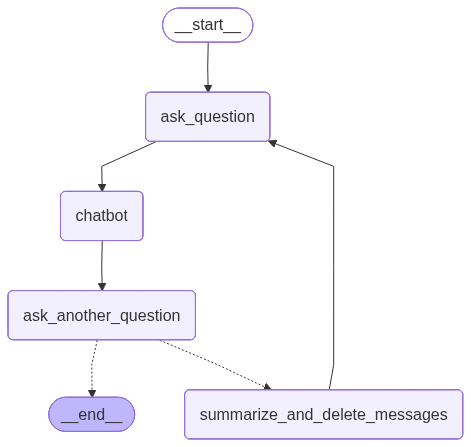

In [37]:
graph_compiled

Step 7: Test the graph

In [38]:
graph_compiled.invoke({"messages": [], "summary": ""})


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

who is iqbal?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Muhammad Iqbal (1', 'extras': {'signature': 'Cs8DAXLI2nw5YySNKI8uRvAf1iVN9geo2eQLdfGoHDPdQCXtr7uPxbAJfLXe6yCTvYcLfqBNVpyZw6RHui13G2ap9eXHfVNOOZ9+gLkQurWwltw7kX8QFkOT5XsoxSEsHXHw0YWFQRcFClDBmIwigIQeYXkb12MCWW1T8wa18D8A3APmTi4FpPmM7yo1WEnA1IO+KB+zrYY3mw5xhoNCgv0oKOyRcToEpF6CbKcrcL7nPH4bjyU287g2L/fw0IkA+QUX6DRhFj1WfZpGiySwVt9Kk6DZ62pPgYFlduymdD5RRFt3/0QADxmMl9TxhYAqYv+YPFhiop9/RGFjO91r8dD9fIHMcLhxv7XxdbF+yb+BajOKZcbf6jyp57O7jvK743YTdBLk+KAmmIYTVr8ao4DsgPL4AhgcDRFLmpg6r1IZFTXb07bOebPnU5iVdPcUCscImRt1Krq86skT1OfijnM16Hzkqt6fzgTGM07/RjdG45WEfEOhPtl5+W1hU4Zp4l4+Vr6Mis4/HQcT+4AwKrq5iGQ/mREyN8t2R29lFtyNpsQOY

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='aed003b9-d7e5-4746-910e-0dc43fc905fe', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='when was he born?', additional_kwargs={}, response_metadata={}, id='de6f544a-fe6c-4016-b0d8-d581e9420309'),
  AIMessage(content='I apologize, but I don\'t have enough information to answer that question.\n\nThe previous context you provided was: "here\'s quick summary of what\'s been disscuss so far: . keep this in mind as you answer the next question."\n\nSince the summary was empty (or not provided to me), I don\'t know who "he" is.\n\nCould you please tell me who you are asking about?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-preview-09-2025', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c2364-781c-7ff0-9c8b-181874bd3a54-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 4